In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import itertools
from constants import *
from submodels import *

In [2]:
# Doesn't do error bars because that's too hard to visualize
def binned_plot_2d(xs, ys, zs, nbins_x = 10, nbins_z = 10, ax = None):
    if ax is None:
        ax = plt.figure().add_subplot(project='3d')

    assert(len(xs) == len(ys) == len(zs))
    N = len(xs)

    argsort_x = np.argsort(xs) // (N // nbins_x)
    argsort_z = np.argsort(zs) // (N // nbins_z)
    argsort_y = argsort_x * (N // nbins_z) + argsort_z

    x_points = [x for (x, z) in itertools.product(argsort_x, argsort_z)]
    z_points = [z for (x, z) in itertools.product(argsort_x, argsort_z)]

    y_points = [ys[argsort_y == idx].mean() for idx in range(len(argsort_y))]

    ax.scatter(x_points, y_points, z_points)

In [3]:
df_all = pd.read_csv("train.csv").rename(name_remap, axis=1)
train_split = np.random.random(df_all.shape[0]) < 0.9
df_train = df_all[train_split]
df_dev = df_all[~train_split]

In [6]:
def retail_algorithm(pred_edge: float, stk: str, xchg: str, px: float, sz: int, dir: str, sm_naive: float) -> bool:
    trap = trapezoids[(xchg, stk)]

    real_pred_edge = pred_edge + trap.calc(sm_naive)
    if real_pred_edge > 0:
        return True
    else:
        return False

def algorithm(pred_edge: float, stk: str, xchg: str, px: float, sz: int, dir: str, cp_naive: str, sm_naive: float) -> bool:
    if cp_naive != 'R':
        return False
    
    return retail_algorithm(pred_edge, stk, xchg, px, sz, dir, sm_naive)

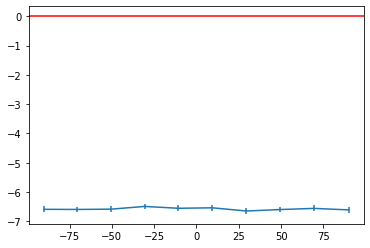

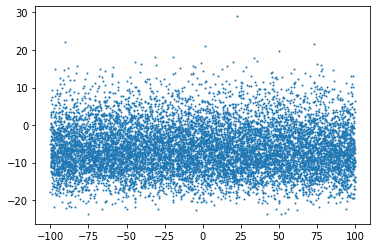

In [118]:
plt.scatter(df.sm, df.real_edge, s=1)
plt.show()

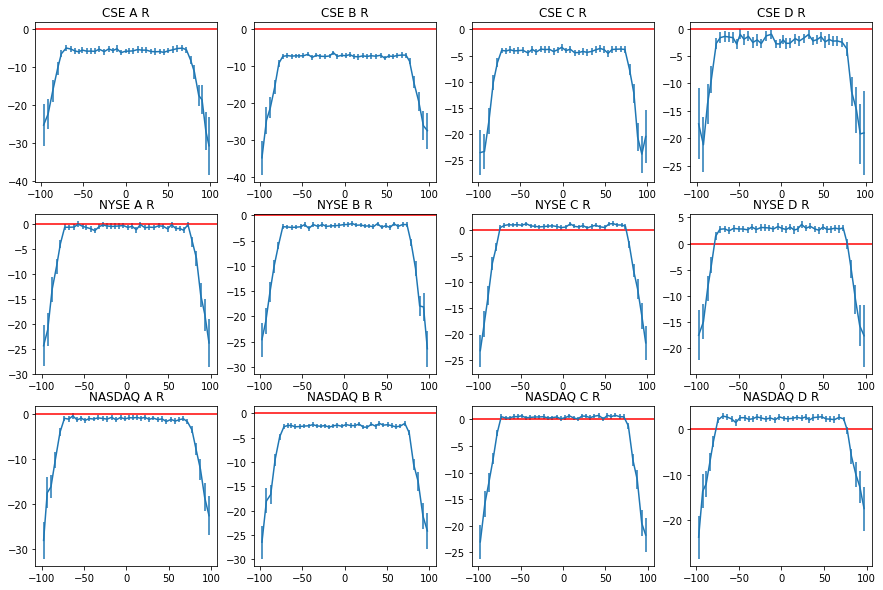

In [144]:
fig, axs = plt.subplots(3, 4)

for i, j, k in itertools.product(range(len(exchanges)), range(len(stocks)), range(1)):
    xchg = exchanges[i]
    stk = stocks[j]
    # part = parties[k]
    part = 'R'
    df = df_train[(df_train.xchg == xchg) & (df_train.stk == stk) & (df_train.cp == part)]

    row = k * 3 + i
    col = j

    binned_plot(df.sm, df.real_edge - df.pred_edge, 40, axs[row][col])
    axs[row][col].set_title(f"{xchg} {stk} {part}")
    axs[row][col].axhline(0, c='r')

fig.set_size_inches(15, 10)